# EEG Data Exploration


In [6]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat

%matplotlib inline

## 1. Load Data

In [ ]:
# 1. Load the .mat file
MAT_FILE = "../../../preprocessed_data/sub-001.mat"
mat = scipy.io.loadmat(MAT_FILE)

# 2. Get the main struct 
main_struct = mat['cellArray'][0, 0]

# 3. Extract Fields 

# --- DATA SHAPE ---
raw_data = main_struct['data'][0, 0]

# --- SRATE ---
# We grab the raw [0,0] version here
raw_srate = main_struct['srate'][0, 0]

# --- XMIN (Start Time) ---
# You were missing this extraction step!
raw_xmin = main_struct['xmin'][0, 0]

# --- CHANNELS ---
chan_structs = main_struct['chanlocs'][0, 0] 
ch_names = [ch['labels'][0] for ch in chan_structs[0]]

# 4. Cleaning Data Types (The Fix)

# FIX: Use 'raw_srate' and 'raw_xmin', NOT 'eeg_struct'
sfreq = raw_srate.item()
tmin = raw_xmin.item()

# Clean Channel Names
clean_ch_names = []
for ch in ch_names:
    # If it's a numpy array, use .item() to get the content
    if isinstance(ch, np.ndarray):
        ch = ch.item()
        # Sometimes it's nested twice, so check again
        if isinstance(ch, np.ndarray):
            ch = ch.item()
    clean_ch_names.append(str(ch))

# --- VERIFICATION ---
print(f"Data Shape: {raw_data.shape}")   
print(f"Cleaned Srate: {sfreq} (Type: {type(sfreq)})")
print(f"Cleaned tmin: {tmin}")
print(f"Cleaned Channels (First 5): {clean_ch_names[:5]}") 

# --- RESHAPE FOR PYTHON ---
# Transpose to (Trials, Channels, Time)
X = np.transpose(raw_data, (2, 0, 1))
print(f"Final Training Input Shape: {X.shape}")

Data Shape: (30, 17500, 60)
Cleaned Srate: 500 (Type: <class 'int'>)
Cleaned tmin: -3
Cleaned Channels (First 5): ['Fp1', 'Fz', 'F3', 'F7', 'FT9']
Final Training Input Shape: (60, 30, 17500)


## 2. Use MNE for further processing

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Original data (note the spike at 0s):


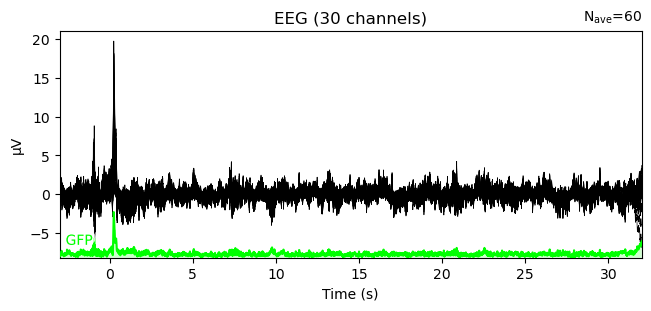

Applying baseline correction (mode: mean)


C:\Users\yanni\AppData\Local\Temp\ipykernel_30208\305553653.py:41: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsArray'>.tmax (31.998 s)
  epochs_stimulus = epochs.copy().crop(tmin=0.1, tmax=32.0)


Cleaned Stimulus Data (Artifact removed, baseline corrected):


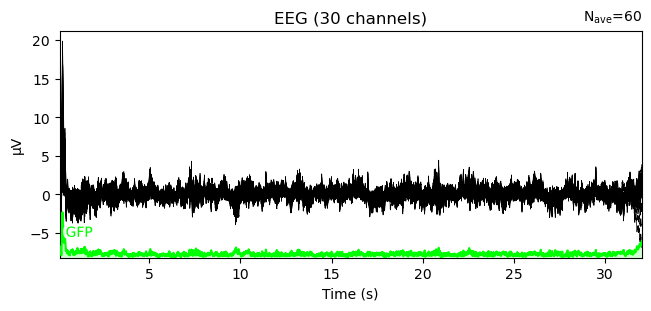

Final Training Shape: (60, 30, 15950)


In [15]:
# 1. Clean the Metadata (CRITICAL STEP)
# We use .item() to convert numpy arrays to standard python numbers
sfreq_cleaned = main_struct['srate'][0, 0].item()  # Becomes 500.0 (float)
tmin_cleaned = main_struct['xmin'][0, 0].item()    # Becomes -3.0 (float)

# 2. Clean Channel Names
# Ensure ch_names is a list of strings, not a list of numpy arrays
raw_chan_structs = main_struct['chanlocs'][0, 0] 
raw_labels = [ch['labels'][0] for ch in raw_chan_structs[0]]

ch_names_cleaned = []
for label in raw_labels:
    # Handle the nesting to get a clean string
    if isinstance(label, np.ndarray):
        label = label.item()
    if isinstance(label, np.ndarray): # Double check for double nesting
        label = label.item()
    ch_names_cleaned.append(str(label))

X_volts = raw_data / 1e6 
X_volts = np.transpose(X_volts, (2, 0, 1)) # Transpose to (60, 30, 17500)

# 2. CREATE EPOCHS
# We define the full range first (-3s to 32s)
info = mne.create_info(ch_names=ch_names_cleaned, sfreq=sfreq, ch_types='eeg')
epochs = mne.EpochsArray(X_volts, info, tmin=-3.0)

# --- VISUALIZATION 1: RAW (With Artifact) ---
print("Original data (note the spike at 0s):")
epochs.average().plot(gfp=True)

# 3. APPLY BASELINE CORRECTION
# We use the time from -3.0s to -0.1s as the "zero" level.
# We stop at -0.1 to avoid including the rising edge of the artifact spike.
epochs.apply_baseline(baseline=(-3, -0.1))

# 4. EXTRACT STIMULUS (Cropping)
# We cut the data to keep only the post-stimulus part.
# We start at 0.1s to slice off the hardware artifact.
# We end at 32s (or shorter if your model needs less data).
epochs_stimulus = epochs.copy().crop(tmin=0.1, tmax=32.0)

# --- VISUALIZATION 2: CLEAN INPUT FOR MODEL ---
print("Cleaned Stimulus Data (Artifact removed, baseline corrected):")
epochs_stimulus.average().plot(gfp=True)

# 5. EXPORT FOR TRAINING
# This is the array you feed into your model
# Shape will be (60, 30, ~16000) depending on crop
X_train = epochs_stimulus.get_data() 
print(f"Final Training Shape: {X_train.shape}")

## 3. Sanity Check individual channels

--- INSPECTING CHANNEL: Cz ---
Plotting ERP Image (Trial Consistency)...
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yanni\AppData\Local\Temp\ipykernel_30208\3227742742.py:11: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=CHANNEL_TO_INSPECT, combine=None, vmin=-30, vmax=30, title=f"ERP Image: {CHANNEL_TO_INSPECT}")


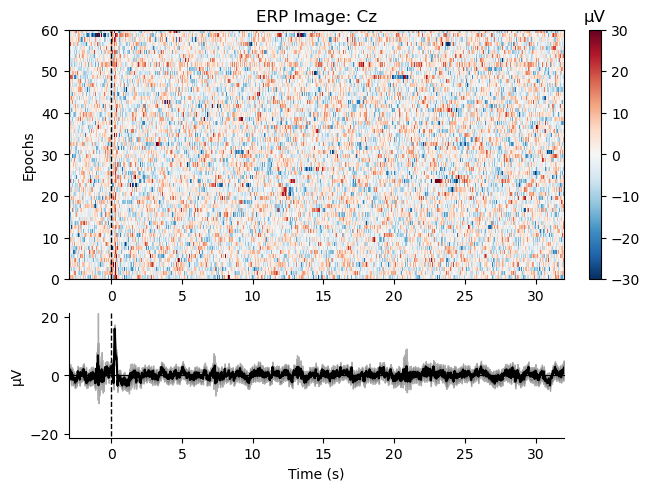

Plotting Power Spectral Density...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Need more than one channel to make topography for eeg. Disabling interactivity.

--- STATISTICS FOR Cz ---
Max Amplitude: 4.13e-04 V
Min Amplitude: -1.60e-04 V
Mean (Should be near 0): 1.64e-07 V
Std Dev (Variability): 7.79e-06 V
STATUS: Variance seems within normal EEG range.


C:\Users\yanni\AppData\Local\Temp\ipykernel_30208\3227742742.py:19: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd(picks=CHANNEL_TO_INSPECT, fmin=1, fmax=60).plot(picks=CHANNEL_TO_INSPECT)
c:\Users\yanni\anaconda3\envs\eeg_classification\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


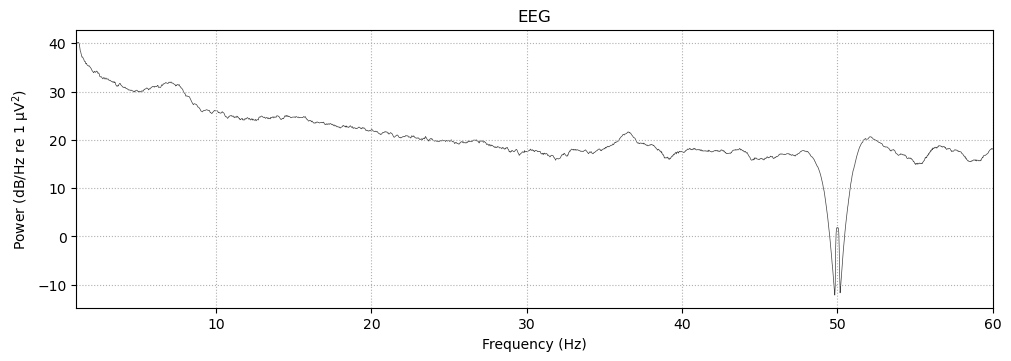

In [17]:
# --- CONFIGURATION ---
CHANNEL_TO_INSPECT = 'Cz' 
# ---------------------

print(f"--- INSPECTING CHANNEL: {CHANNEL_TO_INSPECT} ---")

# 1. VISUALIZATION: ERP Image (Time Series across Trials)
# This shows color-coded voltage for all 60 trials stacked vertically.
# Great for seeing if one specific trial is noisy or if the response is consistent.
print(f"Plotting ERP Image (Trial Consistency)...")
epochs.plot_image(picks=CHANNEL_TO_INSPECT, combine=None, vmin=-30, vmax=30, title=f"ERP Image: {CHANNEL_TO_INSPECT}")

# 2. VISUALIZATION: Power Spectral Density (PSD)
# This checks the frequency content. 
# Look for a curve that goes down as frequency goes up (1/f).
# Look for spikes at 50Hz (Line noise) or peaks at 10Hz (Alpha waves).
print(f"Plotting Power Spectral Density...")
# Note: fmax=60 because you filtered 0.5-60Hz in Matlab
epochs.compute_psd(picks=CHANNEL_TO_INSPECT, fmin=1, fmax=60).plot(picks=CHANNEL_TO_INSPECT)

# 3. STATISTICS: Numerical Health Check
# Extract raw numbers for this channel: Shape (60 trials, 17500 timepoints)
ch_data = epochs.get_data(picks=CHANNEL_TO_INSPECT) 

# Flatten to treat as one long stream for stats
ch_flat = ch_data.flatten()

print(f"\n--- STATISTICS FOR {CHANNEL_TO_INSPECT} ---")
print(f"Max Amplitude: {np.max(ch_flat):.2e} V")
print(f"Min Amplitude: {np.min(ch_flat):.2e} V")
print(f"Mean (Should be near 0): {np.mean(ch_flat):.2e} V")
print(f"Std Dev (Variability): {np.std(ch_flat):.2e} V")

# 4. Check for 'Flat' or 'Dead' channel
if np.std(ch_flat) < 1e-10: # Extremely low variance
    print("WARNING: This channel appears DEAD/FLAT.")
elif np.std(ch_flat) > 100e-6: # Very high variance (adjust threshold as needed)
    print("WARNING: This channel appears extremely NOISY.")
else:
    print("STATUS: Variance seems within normal EEG range.")